* Romain Pous, 2021
* Detects date of same cycle for ARGO profilers
* Computes distance between ARGO profilers
* Computes steric height for ARGO datas
* Computes altimetry height for aviso datas
* Computes a grid of distance between ARGO profilers that have their cycle at the same date.



To use this code you must:

-Download the AVISO data from https://resources.marine.copernicus.eu/products. Select the L4 data for the ocean area you wish to use. We download sea level anomaly data to compare with steric height anomalies calculated from ARGO data.

The flow of this notebook is as follows:

##### 1) Float identification

We look for the presence of ARGO floats in a given area of the ocean in a given year. A map of the area is constructed and we obtain this list of floats. We check thereafter that these floats continue to survey the oceans the year N+1 and the year N+2 in order to have a set of floats functioning on 3 years. 

##### 2) Creation of files by float

We then gather in a file the 3 years data of a profiler, and we apply this method to all the selected floats. 

##### 3) Profiler class

We produce profiler class instances to be able to easily manipulate the data afterwards.

##### 4) Detection of similar ARGO cycles

For two profilers, we identify how many cycles are realized relatively at the same time (on a N_group days window). We then calculate the distance between the profilers at the time of cycles performed at a close date

##### 5) Generalization and proximity grid

We generalize these codes. For a profiler, we determine if its cycle is carried out at the same time as others and we calculate the distance which separates it from these other floats. A grid then summarizes over time which profilers are operating at the same time as the first one and at what distance they are.

##### 6) Sea level height differences

We can now compare one ARGO profiler to another properly and we can make differences between steric and altimetry height to make experiments over them.

In [15]:
#To deal with data
import xarray as xr
import gsw
import seawater as sw
import os

#For basic calculus
import numpy as np
import numpy.ma as ma
from math import ceil
import scipy.stats as ss
from math import *
import math
from scipy import interpolate

#For the plots
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plot

params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}

plot.rcParams.update(params)

#To deal with exemple
import random

#For the plots
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

import pylab as plot
params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}

plot.rcParams.update(params)

#the path where all data are stored
path_occiput_obs='/mnt/pousr/old-equipes/IGE/meom/MODEL_SET/ORCA025.L75/ORCA025.L75-OCCITENS/OBS'
#the specific path where data are extracted for year 2010
path_detar=path_occiput_obs+'/OBS-enact_y2010'
#the path to the file for one run (the 1st)
one_file=path_detar+'/ORCA025.L75-OCCITENS.001_y2010_enact_fdbk.nc'

#opening one file
ds_one=xr.open_dataset(one_file,decode_times=False)

In [ ]:
def Map(ds,max_lat,min_lat,max_long,min_long):
    """Mapping function. It plots ARGO profilers for a selected area and gives station identifier.
        - ds is the opened file where your ARGO data set is,
        - others parameters are needed for are selection.
        - print a map of profiler in the area an return identifier for each profiler"""
    
    fig=plt.figure(figsize=(20,15))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((max_long,min_long,min_lat, max_lat))
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                              alpha=0.5)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)
    plt.title('ARGO profilers between 10°-60°N and 10°-60°O in 2010')
    
    a = []#liste des identifiants
    num=np.where(ds.STATION_TYPE==b' 831')
    colors=cm.viridis(np.linspace(0,1,365))
    n_profiler=len(num[0])
    for j in range(n_profiler):
        ind=np.where(ds.STATION_IDENTIFIER==ds.STATION_IDENTIFIER[num[0][j]])
        if num[0][j]==ind[0][0]:
            one_profile_lon=ds.LONGITUDE[num[0][j]]
            one_profile_lat=ds.LATITUDE[num[0][j]]
            if (one_profile_lat>min_lat and one_profile_lat<max_lat and one_profile_lon>min_long and one_profile_lon<max_long):
                a = np.append(a, num[0][j]) #liste des identifiants
                n=len(ind[0])
                i=0
                one_profile_lon=ds.LONGITUDE[ind[0][i]]
                one_profile_lat=ds.LATITUDE[ind[0][i]]
                plt.scatter(one_profile_lon,one_profile_lat,c='k',linewidth=2, s=25,
                transform=ccrs.PlateCarree(),zorder=1) 
        
    
    plt.colorbar(label='Days')
    plt.clim(10,365)
    
    print('Argo Identifiers in the area are : ',a)
    print('There are ',len(a),'Argo station(s)')
    
    return a

In [16]:
def selec_one_argo_one_year_all_runs(station,year):
    """File selection function. It selects all datas for a profiler from one year.
        - station is the station identifier,
        - year is the year selected."""
    #first run first
    path=path_occiput_obs+'/OBS-enact_y'+str(year)
    file1=path+'/ORCA025.L75-OCCITENS.001_y'+str(year)+'_enact_fdbk.nc'
    ds1=xr.open_dataset(file1,decode_times=False)
    stations=ds1.STATION_IDENTIFIER
    ind=np.where(stations==station)
    ds1_argo_selec=ds1.sel(N_OBS=ind[0]) 

    return ds1_argo_selec
    
    
def selec_one_argo_years_all_runs(station,year1,year2):
    """File selection function. It selects all datas for a profiler for 3 years.
        - station is the station identifier,
        - years are the years selected."""
    #first year first
    ds_concat=selec_one_argo_one_year_all_runs(station,year1)
    #loop on the other years
    for year in np.arange(year1+1,year2+1):
        ds=selec_one_argo_one_year_all_runs(station,year)
        ds_concat=xr.concat([ds_concat,ds],dim='N_OBS')

    #write on disk
    stat=str(station.values)
    str_stat=stat[2:10]
    ds_concat.to_netcdf('/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles'+str(str_stat)+'_y'+str(year1)+'-'+str(year2)+'_r1-50.nc')

# Path to datas

We need to select 3 years for our study. It corresponds to the lifetime of an ARGO profiler.

In [17]:
path_detar0=path_occiput_obs+'/OBS-enact_y2010'
#the path to the file for one run (the 1st)
one_file0=path_detar0+'/ORCA025.L75-OCCITENS.001_y2010_enact_fdbk.nc'
#opening one file
ds_0=xr.open_dataset(one_file0,decode_times=False)

path_detar1=path_occiput_obs+'/OBS-enact_y2011'
#the path to the file for one run (the 1st)
one_file1=path_detar1+'/ORCA025.L75-OCCITENS.001_y2011_enact_fdbk.nc'
#opening one file
ds_1=xr.open_dataset(one_file1,decode_times=False)

path_detar2=path_occiput_obs+'/OBS-enact_y2012'
#the path to the file for one run (the 1st)
one_file2=path_detar2+'/ORCA025.L75-OCCITENS.001_y2012_enact_fdbk.nc'
#opening one file
ds_2=xr.open_dataset(one_file2,decode_times=False)

We call here our Map function to indentify profiler in our area

In [18]:
N_Map_argo=Map(ds_0,60,40,-10,-30)

NameError: name 'Map' is not defined

We can also save this list to use it quickly (map computing last 15 minutes)

In [19]:
#da=xr.DataArray(N_ARGO)
#da.to_netcdf('/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles_y2010_2012.nc')
N_argo_file='/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles_y2010_2012.nc'
ds_N_argo_file=xr.open_dataset(N_argo_file,decode_times=False)
ds_N_argo_file['ID_argo'] = ds_N_argo_file['__xarray_dataarray_variable__']
ds_N_argo_file = ds_N_argo_file.drop(['__xarray_dataarray_variable__'])

###### List of profiler deployed in 2010 in our area :

In [20]:
N_Map_argo=ds_N_argo_file.ID_argo
len(N_Map_argo)

124

###### Are profilers working in 2011 ? in 2012 ?

We need how many profilers deployed in 2010 are still working in 2012.

In [21]:
def N_profilers(N_ARGO,ds_0,ds_1,ds_2):
    """Determines list of profilers indices that are working in N+1 and N+2 years.
    Input: List of ARGO indices in the map and the year selected.
    Output: List of ARGO indices in the map and alive 2 years after."""
    L=np.zeros(len(N_ARGO))
    J=np.zeros(len(N_ARGO))
    N_ARGO_2010=np.zeros(len(N_ARGO))
    for j in range (len(N_ARGO)):
        N_ARGO_2010[j]=N_ARGO[j]
    for j in range (len(N_ARGO)):
        ind=np.where(ds_0.STATION_IDENTIFIER==ds_0.STATION_IDENTIFIER[int(N_ARGO[j])])
        L[j]=len(ds_one.JULD[ind[0]])
        if L[j]>30:
            N_ARGO_2010[j]=0
    liste_2010=np.where(N_ARGO_2010>0)

    N_ARGO_2011=[]             
    for j in range(len(N_ARGO[liste_2010])):
        if ds_0.STATION_IDENTIFIER[int(N_ARGO[liste_2010][j])] in ds_1.STATION_IDENTIFIER:
            N_ARGO_2011=np.append(N_ARGO_2011,N_ARGO[liste_2010][j])
        
    N_argo_profiler=[]    
    for j in range(len(N_ARGO_2011)):
        if ds_0.STATION_IDENTIFIER[int(N_ARGO_2011[j])] in ds_2.STATION_IDENTIFIER:
            N_argo_profiler=np.append(N_argo_profiler,N_ARGO_2011[j])
    
    return N_argo_profiler

In [22]:
N_ARGO_2012=N_profilers(N_Map_argo,ds_0,ds_1,ds_2)

### STERIC HEIGHT

In [92]:
def colocalisation(argo):
    """Determines indices for our altimetry dataset that can be colocalized with our ARGO profiler.
    -Input : profiler class.
    -Return latitude and longitude indices for altimetry dataset."""
    lat,long=[],[]
    for j in range(len(argo.JULD)):
        Diff_lat=ds_alt.latitude-argo.LATITUDE[j]
        minimum_lat=abs(Diff_lat).min()
        ind_lat = np.where(abs(Diff_lat)==minimum_lat)
        colocalisation_lat=ds_alt.latitude[ind_lat[0][0]]
        lat.append(colocalisation_lat)

        Diff_long=ds_alt.longitude-argo.LONGITUDE[j]
        minimum_long=abs(Diff_long).min()
        ind_long = np.where(abs(Diff_long)==minimum_long)
        colocalisation_long=ds_alt.longitude[ind_long[0][0]]
        long.append(colocalisation_long)
    
    return lat,long
            

In [24]:
class Profiler:
    """Profiler class.
    -self.JULD is an array for date of each cycle,
    -self.PSAL_OBS is a salinity array for each cycle and each depth,
    -self.POTM_OBS is a temperature array for each cycle and each depth,
    -self.DEPTH is an array with depths,
    -self.LATITUDE and self.LONGITUDE"""
    def __init__(self, file = None, bias = None, **kwargs):
        """init methode for our class Profiler.
        -File can be filled with the path of a file to copy ARGO datas from ARGO dataset.
        Otherwise, Profiler will represent a random profiler.
        -csr can be filled to compute steric height."""

        csr=kwargs.get('csr', None)
        alt=kwargs.get('alt', None)
        
        if file is not None:
            self.readfile(file)
        else:
            self.create_random_profile()
                
        if csr is not None: 
            self.steric_height = self.compute_steric_height(bias)
        else:
            self.steric_height = 'Oops, please ask to compute steric height.'
            
        if alt is not None: 
            self.altimetry_height = self.compute_altimetry_height()
        else:
            self.altimetry_height = 'Oops, please ask to compute altimetry height.'
                
    def readfile(self,file):
        """Open and read file for an ARGO profiler.
        -Return an error if file doesn't exist or extract datas from an ARGO dataset."""
        # verifie que le fichier existe   
        filexist=os.path.isfile(file)
        if filexist == False:
            self.print_error('nofile')
        else:
            ds_argo=xr.open_dataset(file,decode_times=False) 
            # on ouvre, on lit le fichier
            self.JULD=ds_argo.JULD
            self.PSAL_OBS=ds_argo.PSAL_OBS
            self.POTM_OBS=ds_argo.POTM_OBS
            self.DEPTH=ds_argo.DEPTH
            self.LATITUDE=ds_argo.LATITUDE
            self.LONGITUDE=ds_argo.LONGITUDE
            self.STATION_IDENTIFIER=ds_argo.STATION_IDENTIFIER
            
    def create_random_profile(self):
        """ Create a random profile to compute and test steric height function."""
        n_cycle=100
        n_level=150
        self.JULD=np.ones(n_cycle)
        self.PSAL_OBS=99999.0*np.ones((n_cycle,n_level))
        self.POTM_OBS=99999.0*np.ones((n_cycle,n_level))
        self.DEPTH=99999.0*np.ones((n_cycle,n_level))
        self.LATITUDE=np.ones(n_cycle)
        self.LONGITUDE=np.ones(n_cycle)
        for i in range(n_cycle):
            self.JULD[i]=i*10
            self.LATITUDE[i]=random.uniform(23, 26)
            self.LONGITUDE[i]=random.uniform(-33, -27)
            for j in range(n_level-50):
                self.PSAL_OBS[i][j]=random.uniform(35.5, 36)
                self.POTM_OBS[i][j]=random.uniform(5, 7)+random.uniform(-0.01, +0.05)
                self.DEPTH[i][j]=j*200+random.uniform(-2,2)
    
    
    def compute_steric_height(self,bias):
        """Compite steric height for a profiler over time. 
        - self is the opened file that contains ARGO data set,
        - H[0] is an array of steric height in meter filled with steric height for each time step."""
        #Number of ARGO cycle
        n_cycle=len(self.JULD)
        #Number of ARGO levels for a profiler.
        n_level=len(self.DEPTH[0])
        #Gravitational constant 
        g=9.81
        #Pressure reference
        pref=1400
        #H is our steric height matrix
        H=[]
        #bias for our corrupted version of steric height
        self.bias = bias
        
        #Initialisation : we need this step to create our H matrix
        IND=self.verification(0)
        Length=len(IND[0])
        C_Ps=np.zeros(Length)
        C_SA=np.zeros(Length)
        C_CT=np.zeros(Length)
        C_H=np.zeros(n_level)
        
        if self.bias is not None:
            H_b=[]
            C_SA_b=np.zeros(Length)
            C_CT_b=np.zeros(Length)
            C_H_b=np.zeros(n_level)

        for j in range (Length):
            #Conversion depth in sea pressure
            C_Ps[j]=sw.eos80.pres(self.DEPTH[0][IND[0][j]],self.LATITUDE[0])
            #Conversion practical salinity in absolute salinity
            C_SA[j]=gsw.SA_from_SP(self.PSAL_OBS[0][IND[0][j]], C_Ps[j], self.LONGITUDE[0], self.LATITUDE[0])
            #Conversion in situ temperature in absolute temperature
            C_CT[j]=gsw.CT_from_t(C_SA[j], self.POTM_OBS[0][IND[0][j]], C_Ps[j])
            if self.bias is not None :
                C_SA_b[j]=gsw.SA_from_SP(self.PSAL_OBS[0][IND[0][j]], C_Ps[j], self.LONGITUDE[0], self.LATITUDE[0])
                C_CT_b[j]=gsw.CT_from_t(C_SA_b[j], self.POTM_OBS[0][IND[0][j]], C_Ps[j])
        C_H=gsw.geo_strf_dyn_height(C_SA,C_CT,C_Ps,pref)/g  
        if self.bias is not None :
            C_H_b=gsw.geo_strf_dyn_height(C_SA_b,C_CT_b,C_Ps,pref)/g 
        while len(C_H)<n_level:
            C_H=np.append(C_H,0)
            if self.bias is not None :
                C_H_b=np.append(C_H_b,0)
        H=C_H
        if self.bias is not None :
            H_b=C_H_b

        #Steric height loop
        for i in range(n_cycle-1):
            IND=self.verification(i+1)
            Length=len(IND[0])
            C_Ps=np.zeros(Length)
            C_SA=np.zeros(Length)
            C_CT=np.zeros(Length)
            C_H=np.zeros(n_level)
            if self.bias is not None:
                C_SA_b=np.zeros(Length)
                C_CT_b=np.zeros(Length)
                C_H_b=np.zeros(n_level)
                t=self.JULD[i]-self.JULD[0]
            for j in range (Length):
                #Conversion depth in sea pressure
                C_Ps[j]=sw.eos80.pres(self.DEPTH[i+1][IND[0][j]],self.LATITUDE[i+1])
                #Conversion practical salinity in absolute salinity
                C_SA[j]=gsw.SA_from_SP(self.PSAL_OBS[i+1][IND[0][j]], C_Ps[j], self.LONGITUDE[i+1], self.LATITUDE[i+1])
                #Conversion in situ temperature in absolute temperature
                C_CT[j]=gsw.CT_from_t(C_SA[j], self.POTM_OBS[i+1][IND[0][j]], C_Ps[j])
                if self.bias is not None :
                    C_SA_b[j]=gsw.SA_from_SP(self.PSAL_OBS[i+1][IND[0][j]]+t*self.bias, C_Ps[j], self.LONGITUDE[i+1], self.LATITUDE[i+1])
                    C_CT_b[j]=gsw.CT_from_t(C_SA_b[j], self.POTM_OBS[i+1][IND[0][j]], C_Ps[j])
    
            C_H=gsw.geo_strf_dyn_height(C_SA,C_CT,C_Ps,pref)/g
            if self.bias is not None :
                C_H_b=gsw.geo_strf_dyn_height(C_SA_b,C_CT_b,C_Ps,pref)/g 
            while len(C_H)<n_level:
                C_H=np.append(C_H,0)
                if bias is not None :
                    C_H_b=np.append(C_H_b,0)
            H=np.c_[H, C_H]
            if self.bias is not None :
                H_b=np.c_[H_b, C_H_b]
        
        if self.bias is not None :
            return H[0],H_b[0]
        else :
            return H[0]
    
    def compute_altimetry_height(self):
        """Compute altimetry height anomaly for a profiler over time. 
        - self is the opened file that contains ARGO data set,
        - H_alt is an array of altimetry height colocalized for an ARGO profiler."""
        one_file_alt='/home/pousr/Work/dataset-duacs-rep-global-merged-allsat-phy-l4_1636388010406.nc'
        ds_alt=xr.open_dataset(one_file_alt,decode_times=False)
        
        if self.JULD[len(self.JULD)-1]<ds_alt.time[len(ds_alt.time)-1] and self.JULD[0]>ds_alt.time[0]:
            l=len(self.JULD)
            D=np.zeros(l)
            Lat=np.zeros(l)
            Long=np.zeros(l)
            Time=np.zeros(l)
            B=np.zeros(l)
            H_alt=np.zeros(l)
            Lat,Long=colocalisation(self)
            for i in range(l):
                Time[i]=ceil(self.JULD[i])
                ind_time=np.where(ds_alt.time==Time[i])
                ind_lat=np.where(ds_alt.latitude==Lat[i].values)
                ind_long=np.where(ds_alt.longitude==Long[i].values)
                H_alt[i]=ds_alt.sla[ind_time[0][0]][ind_lat[0][0]][ind_long[0][0]]
        
            return H_alt
        else:
            print('Oops, altimetry and argo datas do not match in time. Please verify.')
                
    
    def print_error(self, errtype):
        if errtype == 'nofile':
            print('Oops, the file does not exist. Please double check.')
            
    def verification(self,i):
        """Verification function. It identifies uncorrupted levels.
        - ds is the opened file where your ARGO data set is
        - L is the number of levels for a profile. It's often written as len(ds.DEPTH)
        - i is the i-th cycle of the profiler 
        - ind is an array of uncorrupted levels for one profile"""
        ind=[]
        ind=np.where(self.PSAL_OBS[i]!=99999.0)
        return ind

In [28]:
def Create_profilers(N_ARGO):   
    """Compute profiler instance for each profiler selected previously 
    -Input: List of ARGO indices in the map and alive 2 years after,
    -Output: Profilers instances ."""

    LProfilers=[]
    for i in range (len(N_ARGO)):
        station=ds_0.STATION_IDENTIFIER[int(N_ARGO[i])]
        stat=str(station.values)
        str_stat=stat[2:10]
        onefile='/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles'+str(str_stat)+'_y2010-2012_r1-50.nc'
        #P.append(Profiler(file=onefile,bias=0.000011,**rec))
        LProfilers.append(Profiler(file=onefile))
    return LProfilers       

In [29]:
P=Create_profilers(N_ARGO_2012)

# Cycle identification

In [30]:
#package de ref
one_file_alt='/home/pousr/Work/dataset-duacs-rep-global-merged-allsat-phy-l4_1636388010406.nc'
ds_alt=xr.open_dataset(one_file_alt,decode_times=False)

#Reference for time
Ref_init=ds_alt.time[0]
Ref_end=ds_alt.time[len(ds_alt.time)-1]

#Time list
N_grouped_days=5
N=int(np.round((Ref_end-Ref_init)/N_grouped_days))

def Time_Cycle_Array(t,N,R_i,N_group):
    """Returns an array composed of 1 in the cells where an ARGO profile is realized and 0 otherwise. 
    On the number of years considered, the days are grouped by a group of a desired size by N_group. 
    Input : -t is the profiler indice considered,
    -N is the length for time grouped datas,
    -N_group is the number of days grouped,
    -R_i is the first Julian day of the first year selected."""
    Int_cycle=np.zeros(N)
    for i in range (len(P[t].JULD)):
        k=int((np.round(P[t].JULD[i])-R_i)/N_group)
        if k==N:
            Int_cycle[k-1]=1
        else:
            Int_cycle[k]=1
    return Int_cycle

def SameCycle(T1,T2,N):
    """Determines indices shared for two Time_Cycle_Array arrays, linked to two different profiler.
    Input : -ds1 and ds2 are Profiler 1 and 2, 
    -N is the length for time grouped datas,
    -T1 and T2 are time datas arrays filled with 1 when profiler 1 (or 2) makes one profile, and 0 instead,
    """
    SameCycle=[]
    for i in range(N):
        if T1[i]==1 and T2[i]==1:
            SameCycle.append(i)
    return SameCycle

def Distance(ds1,ds2,N,T1,T2,N_group,R_i):
    """Computes distances for two profilers and for profiles made simultaneously.
    Input : -ds1 and ds2 are Profiler 1 and 2, 
    -N is the length for time grouped datas,
    -T1 and T2 are time datas arrays filled with 1 when profiler 1 (or 2) makes one profile, and 0 instead,
    -N_group is the number of days grouped,
    -R_i is the first Julian day of the first year selected.
    Output : -y is an array filled with distance for profiles made simultaneously and with 0 otherwise,
    -t is an array filed with date."""
    Distance=np.zeros(N)
    y=np.zeros(N)
    t=[]
    SC=SameCycle(T1,T2,N)
    for j in SC:
        D=ds1.JULD-Ref_init
        E=find_nearest(D,j*N_group)
        i2=np.where(ds1.JULD-R_i==E)
        one_profile_lon1=ds1.LONGITUDE[i2[0]]
        LA=ds1.LATITUDE[i2[0]]
        
        D=ds2.JULD-Ref_init
        E=find_nearest(D,j*N_group)
        i2=np.where(ds2.JULD-R_i==E)
        
        one_profile_lon2=ds2.LONGITUDE[i2[0]]
        LB=ds2.LATITUDE[i2[0]]
        
        g=one_profile_lon1-one_profile_lon2
        y[j]= (acos(sin(LA/57.2958)*sin(LB/57.2958)+cos(LA/57.2958)*cos(LB/57.2958)*cos(g/57.2958)))*6371
        t.append(ds2.JULD[i2[0]]-Ref_init)
    return y,t

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def Id_SameCycle(ds1,ds2,N,T1,T2,N_group,R_i):
    """Finds indices for each profiler where two profilers make their profiles simultaneously.
    Input : -ds1 and ds2 are Profiler 1 and 2, 
    -N is the length for time grouped datas,
    -T1 and T2 are time datas arrays filled with 1 when profiler 1 (or 2) makes one profile, and 0 instead,
    -N_group is the number of days grouped,
    -R_i is the first Julian day of the first year selected.
    Output : Arrays of indices for each profiler. It corresponds to profiles made simultaneously.
    """
    SC=SameCycle(T1,T2,N)
    A=np.zeros(len(SC))
    B=np.zeros(len(SC))
    D1=ds1.JULD-Ref_init
    D2=ds2.JULD-Ref_init
    i=0
    for j in SC:
        E=find_nearest(D1,j*N_group)
        i2=np.where(ds1.JULD-R_i==E)
        A[i]=int(i2[0][0])
        E=find_nearest(D2,j*N_group)
        i2=np.where(ds2.JULD-R_i==E)
        B[i]=int(i2[0][0])
        i=i+1
        
    return A,B

def Distance_all_profilers(t,N,nb,R_i,Profiler,N_group):
    """Computes distances between multiple profilers and one selected.Profiles must be done simultaneously.
    Input : -t is the profiler indice considered,
    -nb is the number of others profilers,
    -N is the length for time grouped datas,
    -Profiler is the instance of profilers computed before,
    -N_group is the number of days grouped,
    -R_i is the first Julian day of the first year selected.
    Output : -T is an array filled with distance between profilers and our one profiler, and with 0 otherwise."""
    Y=[]
    T_initial=Time_Cycle_Array(t,N,R_i,N_group)
    Th=Time_Cycle_Array(0,N,R_i,N_group)
    D=Distance(Profiler[t],Profiler[0],N,Th,T_initial,N_group,R_i)[0]
    Y=D
    for h in range(nb-1):
        Th=Time_Cycle_Array(h+1,N,R_i,N_group)
        D=Distance(Profiler[t],Profiler[h+1],N,Th,T_initial,N_group,R_i)[0]
        Y=np.c_[Y, D]
    T=np.transpose(Y)
    return T


We choose to study the 27th profiler.

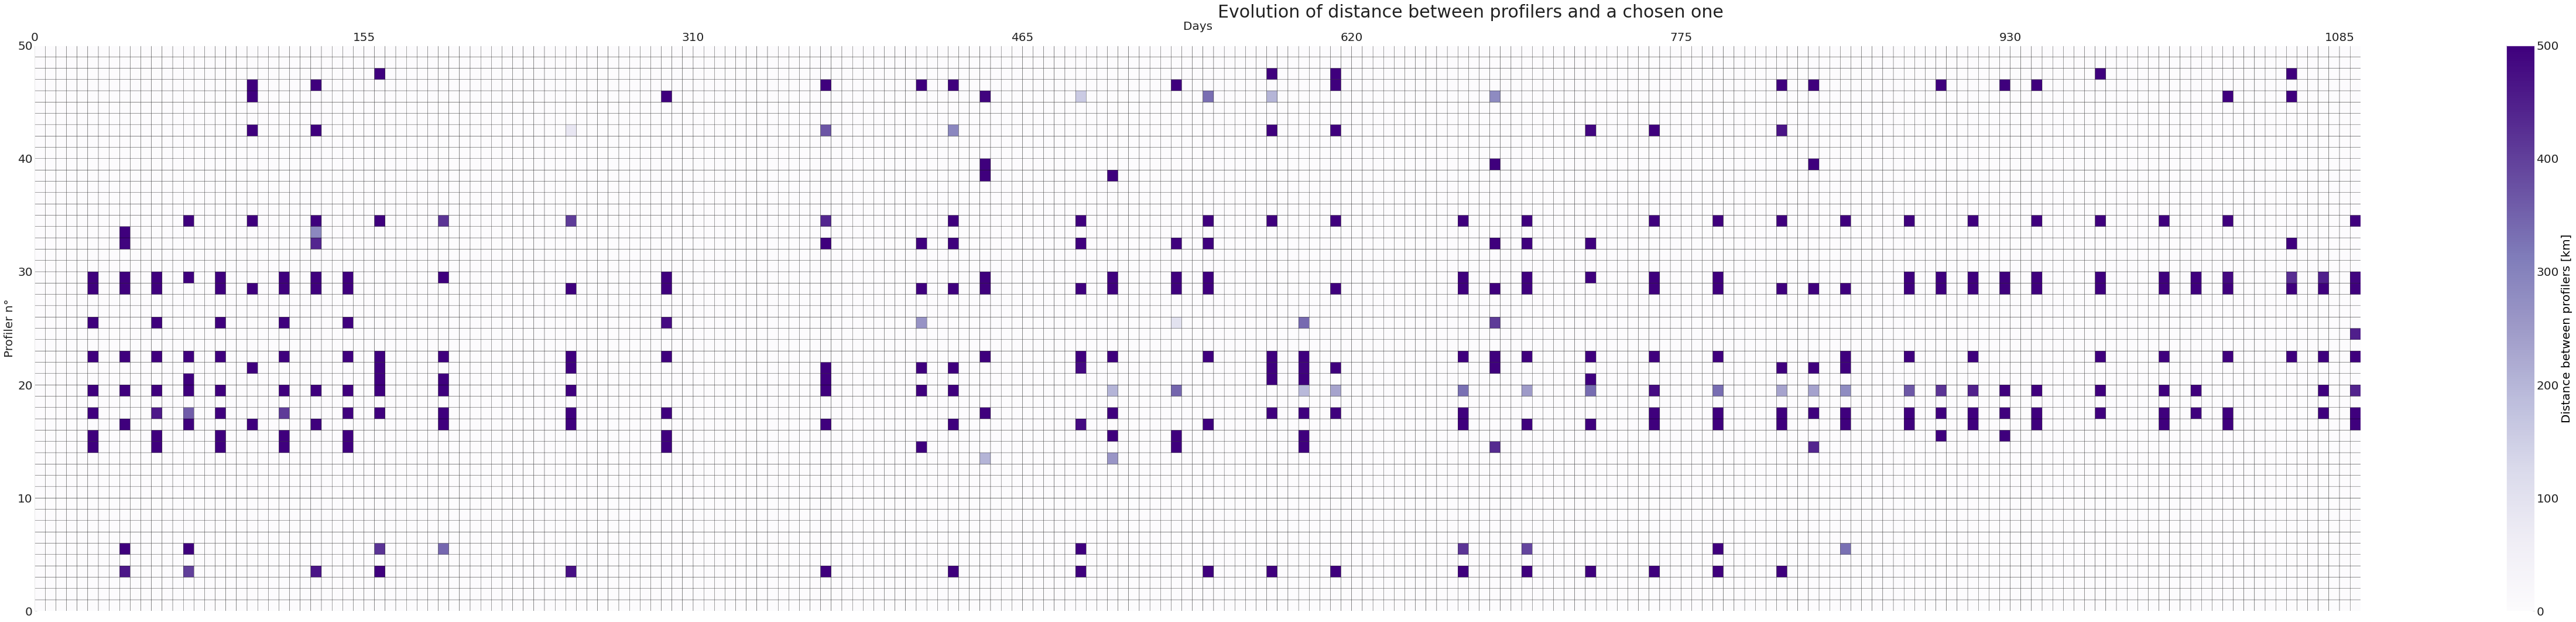

In [32]:
from matplotlib import cycler
colors = cycler('color',['#fc280f', '#5fdcff', '#f4ba26', '#85c54c', '#c6d7e0']) # colors for artists will be cycled from this list by default
plt.rc('figure', facecolor='#FFFFFF') # facecolor is background colour
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#FFFFFF',
       axisbelow=True, grid=True, prop_cycle=colors) # "axisbelow" set axis ticks and gridlines are below all artists
plt.rc('grid', color='#222222', linestyle='solid')
plt.rc('xtick', direction='in', color='#222222')
plt.rc('ytick', direction='in', color='#222222')
plt.rc('patch', edgecolor='#e3e3e3')
plt.rc('lines', linewidth=1.5)


fig = plt.figure(figsize=(70, 15))  # (w,h)
ax = plt.subplot() 
ca=ax.pcolor(T,vmax=500,cmap='Purples', edgecolors='k', linewidths=0.3)
fig.colorbar(ca, ax=ax,label='Distance between profilers [km]')
plt.suptitle('Evolution of distance between profilers and a chosen one ', size=30, color='#222222') 
ax.set_ylabel('Profiler n°',color='#222222')    
ax.set_xlabel('Days',color='#222222')
ax.grid(True, which='both')
ax.xaxis.tick_top()

N_group=3
years=3
default_x_ticks = [j*31 for j in range((years+1)*2)]
x = [i*5 for i in default_x_ticks ] 
plt.xticks(default_x_ticks,x)
ax.xaxis.set_label_position('top')
   


fig.tight_layout()
plt.show()

In [38]:
T=Distance_all_profilers(27,N,len(N_ARGO_2012),Ref_init,P,N_grouped_days)
ind=np.where(T>1)
print('Nearest profiler was at',int(T[ind].min()),'kilometers.')
tmp = np.where(T>1, T, 9999.)
np.argwhere(tmp< tmp.min()+1 )
print('It was the',np.argwhere(tmp< tmp.min()+1 )[0][0],'th profiler and this happened around the',np.argwhere(tmp< tmp.min()+1 )[0][1]*N_grouped_days,'th day.')

Nearest profiler was at 12 kilometers.
It was the 57 th profiler and this happened around the 250 th day.


### With this information, we can now compare the nearest profiler to our chosen one

In [90]:
from matplotlib import cycler
colors = cycler('color',['#fc280f', '#5fdcff', '#f4ba26', '#85c54c', '#c6d7e0']) # colors for artists will be cycled from this list by default
plt.rc('figure', facecolor='#FFFFFF') # facecolor is background colour
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#FFFFFF',
       axisbelow=True, grid=True, prop_cycle=colors) # "axisbelow" set axis ticks and gridlines are below all artists
plt.rc('grid', color='#222222', linestyle='solid')
plt.rc('xtick', direction='in', color='#222222')
plt.rc('ytick', direction='in', color='#222222')
plt.rc('patch', edgecolor='#e3e3e3')
plt.rc('lines', linewidth=1.5)

def plot2(Prof,a,b):
    """Plot steric height and altimetry height for our two profilers.
    -Input : a and b are indices for our class list.
    -Ouput : Differences of height graphics."""
    Ref_init=ds_alt.time[0]
    Ref_end=ds_alt.time[len(ds_alt.time)-1]

    #Time list
    N=int((Ref_end-Ref_init)/3)

    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1])
    fig = plt.figure(figsize=(20, 10))  # (w,h)

    H_argo,H_argo_b=Prof[a].compute_steric_height(bias=0.000011)
    H_alt=Prof[a].compute_altimetry_height()

    H_argo2,H_argo_b2=Prof[b].compute_steric_height(bias=0.000011)
    H_alt2=Prof[b].compute_altimetry_height()  
                      
    Ta=Time_Cycle_Array(a,N,Ref_init,5)
    Tb=Time_Cycle_Array(b,N,Ref_init,5)
        
    AA,BB=Id_SameCycle(Prof[a],Prof[b],N,Ta,Tb,5,Ref_init)
    
    H_argo_SC=np.zeros(len(AA))
    H_argo_b_SC=np.zeros(len(AA))
    H_alt_SC=np.zeros(len(AA))
    k=0
    for i in AA:
        H_argo_SC[k]=H_argo[int(i)]
        H_argo_b_SC[k]=H_argo_b[int(i)]
        H_alt_SC[k]=H_alt[int(i)]
        k=k+1
        
    H_argo2_SC=np.zeros(len(BB))
    H_argo_b2_SC=np.zeros(len(BB))
    H_alt2_SC=np.zeros(len(BB))
    k=0
    for i in BB:
        H_argo2_SC[k]=H_argo2[int(i)]
        H_argo_b2_SC[k]=H_argo_b2[int(i)]
        H_alt2_SC[k]=H_alt2[int(i)]
        k=k+1
    
    Diff_alt=np.zeros(len(AA))
    Diff_argo=np.zeros(len(AA))
    Diff_argob=np.zeros(len(AA))
    for j in range(len(AA)):
    
        Diff_argob[j]=H_argo_SC[j]-H_argo2_SC[j]
        Diff_argo[j]=H_argo_b_SC[j]-H_argo_b2_SC[j]
        Diff_alt[j]=H_alt_SC[j]-H_alt2_SC[j]
        
    
    Y,T_Y=Distance(P[a],P[b],N,Ta,Tb,5,Ref_init)
    Liste_Y=np.where(Y!=0)
    
    ax1 = plt.subplot(gs[0,0])
    #ax1.plot(T_Y, H_argo_SC,color='#fd411e',label='Altimetry anomaly height difference', zorder=1, marker = '+')
    #ax1.plot(T_Y, H_argo_b_SC,color='#0000FF',label='Steric height difference', zorder=1, marker = '+') 
    #ax1.plot(T_Y, Diff_argob,color='#15B01A',label='Steric height with bias difference', zorder=1, marker = '+') 
    
    ax1.plot(T_Y, Diff_alt,color='#fd411e',label='Altimetry anomaly height difference', zorder=1, marker = '+')
    ax1.plot(T_Y, Diff_argo,color='#0000FF',label='Steric height difference', zorder=1, marker = '+') 
    ax1.plot(T_Y, Diff_argob,color='#15B01A',label='Steric height with bias difference', zorder=1, marker = '+') 

    
    ax1.set_ylabel('Height [m]',color='#222222')    
    ax1.legend(labelcolor='#222222',fontsize='large') 
    ax1.set_xlabel('Time [days]',color='#222222')
    ax1.grid(True, which='both')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    
    
    
    ax2 = plt.subplot(gs[0,1])
    ax2.plot(T_Y, Y[Liste_Y[0]],color='#0000FF',label='Distance between profiler', zorder=1, marker = '+')
    ax2.set_ylabel('Distance [km]',color='#222222')    
    ax2.legend(labelcolor='#222222',fontsize='large') 
    ax2.set_xlabel('Time [days]',color='#222222')
    ax2.grid(True, which='both')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')
    
    plt.suptitle('Sea level anomaly differences for two ARGO profilers ', size=30, color='#222222')    

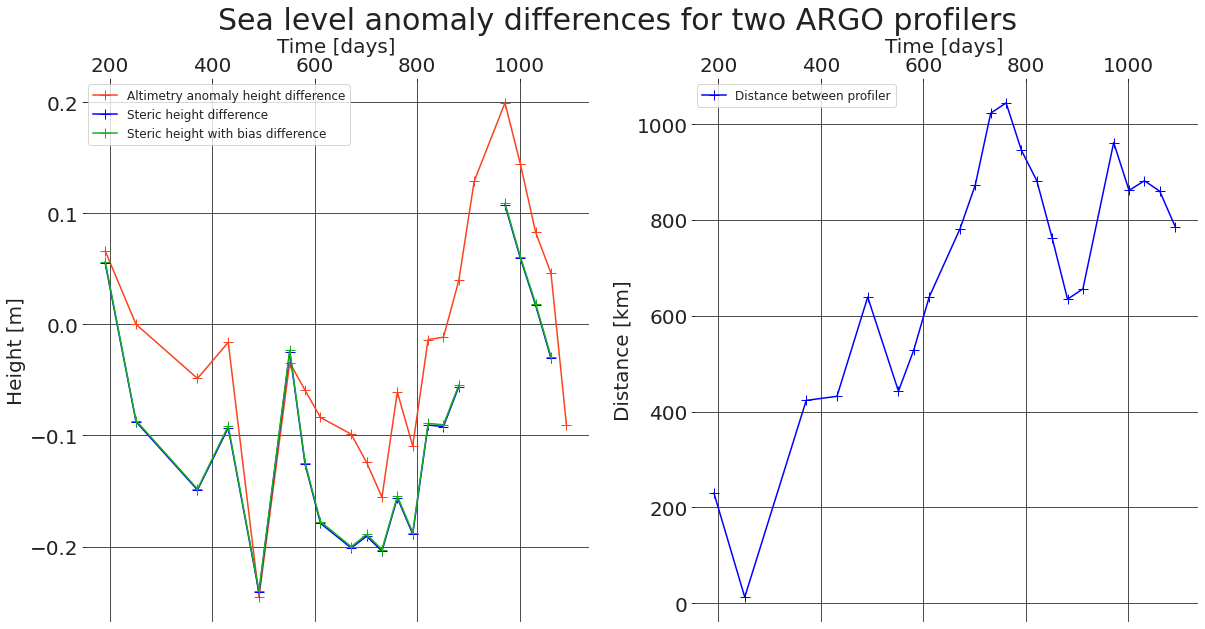

In [91]:
plot2(P,27,57)